<a href="https://colab.research.google.com/github/nabkem22/p53-machinelearning/blob/main/MLSubstatePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import seaborn as sns
import tensorflow_datasets as tfds


SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

In [ ]:
df = pd.read_csv(r'1tup_wtandy220c218-223.csv')

print(df)

      Type  Pairwise Ene     phi:2     psi:2
0        0      117.5830 -130.0253  122.5336
1        0      115.6775 -143.1288  131.1374
2        0      110.4923  -85.5371  144.5525
3        0      118.6547 -132.5132  137.1240
4        0      120.6676 -138.8277  132.5149
...    ...           ...       ...       ...
4995     1       46.3902  -85.1249  150.7213
4996     1       37.4889  -71.2253  132.0501
4997     1       14.2643  -53.6622  130.8367
4998     1       11.8225  -72.7510  146.3317
4999     1       22.0156  -69.2759  138.7991

[5000 rows x 4 columns]


In [ ]:
df.head()

,Type,Pairwise Ene,phi:2,psi:2
0,0,117.5830,-130.0253,122.5336
1,0,115.6775,-143.1288,131.1374
2,0,110.4923,-85.5371,144.5525
3,0,118.6547,-132.5132,137.1240
4,0,120.6676,-138.8277,132.5149


In [ ]:
df.tail()

,Type,Pairwise Ene,phi:2,psi:2
4995,1,46.3902,-85.1249,150.7213
4996,1,37.4889,-71.2253,132.0501
4997,1,14.2643,-53.6622,130.8367
4998,1,11.8225,-72.7510,146.3317
4999,1,22.0156,-69.2759,138.7991


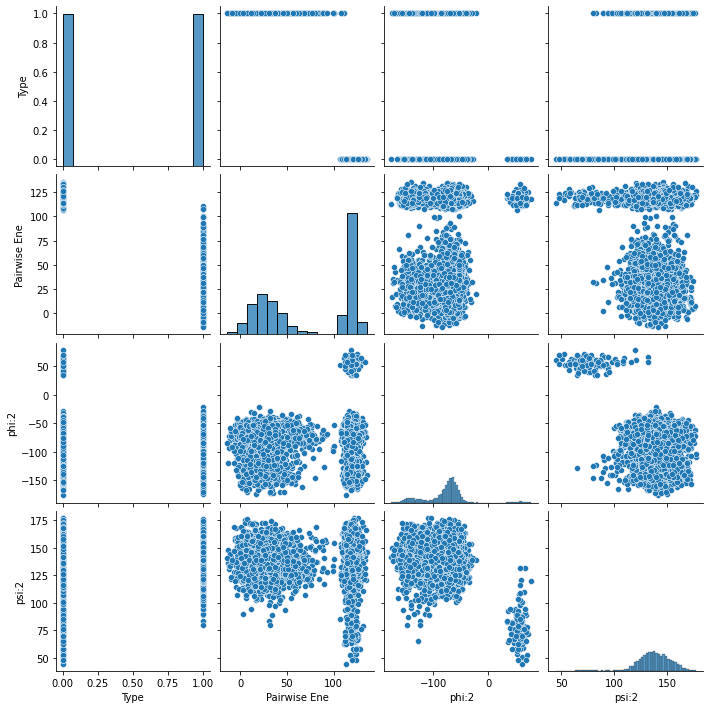

In [ ]:
sns.pairplot(originaldf)
plt.savefig('seaborn plot.png')

In [ ]:
target=df.pop('Type')

In [ ]:
def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    # Only allows for equal validation and test splits
    assert val_split == test_split 

    # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(train_split * len(df)), int((1 - val_split - test_split) * len(df))]
    
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    
    return train_ds, val_ds, test_ds

In [ ]:
get_dataset_partitions_pd(df)

(      Type  Pairwise Ene     phi:2     psi:2
 4506     1        1.5812 -152.8225  146.6135
 1273     0      120.9659  -80.0654  160.7886
 357      0      118.1410  -65.0738  150.7351
 478      0      122.6498 -159.4095  149.7108
 356      0      121.0661 -150.9135  141.4551
 ...    ...           ...       ...       ...
 4590     1       41.7384  -66.7636  132.9188
 713      0      125.8415   52.3892   70.5178
 2684     1       31.5667 -110.0996  129.6765
 420      0      114.5170 -146.3166  149.4271
 123      0      126.4460  -96.7444  155.3896
 
 [4000 rows x 4 columns], Empty DataFrame
 Columns: [Type, Pairwise Ene, phi:2, psi:2]
 Index: [],       Type  Pairwise Ene    phi:2     psi:2
 4234     1       14.4398 -73.9526  150.7211
 2285     0      115.6476 -69.8422  143.4408
 2175     0      114.5188 -60.5270  140.5771
 2312     0      120.1743 -52.3387  128.3747
 4985     1       29.9911 -77.1166  130.9429
 ...    ...           ...      ...       ...
 3916     1       18.0410 -50.540

In [ ]:
train_ds = (get_dataset_partitions_pd(df)[0])
test_ds = (get_dataset_partitions_pd(df) [2])

In [ ]:
target = train_ds.pop('Type')

In [ ]:
numeric_feature_names = ['Pairwise Ene','phi:2','psi:2']
numeric_features = train_ds[numeric_feature_names]
train_ds.head()

,Pairwise Ene,phi:2,psi:2
4506,1.5812,-152.8225,146.6135
1273,120.9659,-80.0654,160.7886
357,118.1410,-65.0738,150.7351
478,122.6498,-159.4095,149.7108
356,121.0661,-150.9135,141.4551


In [ ]:
tf.convert_to_tensor(numeric_features)

<tf.Tensor: shape=(4000, 3), dtype=float64, numpy=
array([[   1.5812, -152.8225,  146.6135],
       [ 120.9659,  -80.0654,  160.7886],
       [ 118.141 ,  -65.0738,  150.7351],
       ...,
       [  31.5667, -110.0996,  129.6765],
       [ 114.517 , -146.3166,  149.4271],
       [ 126.446 ,  -96.7444,  155.3896]])>

In [ ]:
normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(numeric_features)

In [ ]:
normalizer(numeric_features.iloc[:3])

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.9322695 , -1.4471544 , -0.91902   ],
       [ 0.89166653, -1.8212565 , -0.3881053 ],
       [ 0.78117895, -0.1770258 ,  0.43969974]], dtype=float32)>

In [ ]:
def get_basic_model():
  model = Sequential([
    Dense(10, activation = "relu"),
    Dense(1, activation = "sigmoid")])
  
  model.compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics=['accuracy'])
  
  return model
  

In [ ]:
model=get_basic_model()
model.fit(numeric_features, target, epochs=15, batch_size=BATCH_SIZE)

Epoch 1/15
2000/2000 [==============================] - 3s 1ms/step - loss: 1.7859 - accuracy: 0.9122
Epoch 2/15
2000/2000 [==============================] - 2s 968us/step - loss: 0.0358 - accuracy: 0.9942
Epoch 3/15
2000/2000 [==============================] - 2s 947us/step - loss: 0.0355 - accuracy: 0.9950
Epoch 4/15
2000/2000 [==============================] - 2s 983us/step - loss: 0.0344 - accuracy: 0.9958
Epoch 5/15
2000/2000 [==============================] - 2s 954us/step - loss: 0.0328 - accuracy: 0.9952
Epoch 6/15
2000/2000 [==============================] - 2s 984us/step - loss: 0.0345 - accuracy: 0.9952
Epoch 7/15
2000/2000 [==============================] - 2s 952us/step - loss: 0.0343 - accuracy: 0.9958
Epoch 8/15
2000/2000 [==============================] - 2s 954us/step - loss: 0.0340 - accuracy: 0.9958
Epoch 9/15
2000/2000 [==============================] - 2s 992us/step - loss: 0.0322 - accuracy: 0.9958
Epoch 10/15
2000/2000 [==============================] - 2s 965us/

In [ ]:
predictions = model.predict(numeric_features)

In [ ]:
print(predictions)

[[9.1209443e-11]
 [1.1684493e-08]
 [3.8302960e-06]
 ...
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]]


In [ ]:
targetlist = target.tolist()
print(targetlist)

[1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 

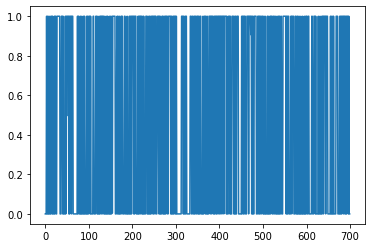

In [ ]:
graphdat = np.squeeze(predictions)
plt.plot(graphdat[3300:4000])
plt.show()

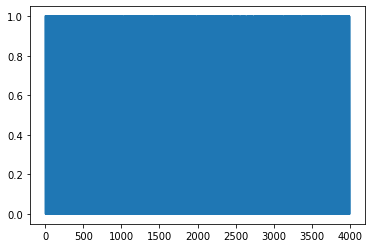

In [ ]:
#originaldf = pd.read_csv('1tup_wtandy220c218-223.csv')
#typelist = first_column = originaldf.iloc[:, 0]
plt.plot(targetlist)
plt.show()

Text(0.5, 1.0, 'Actual')

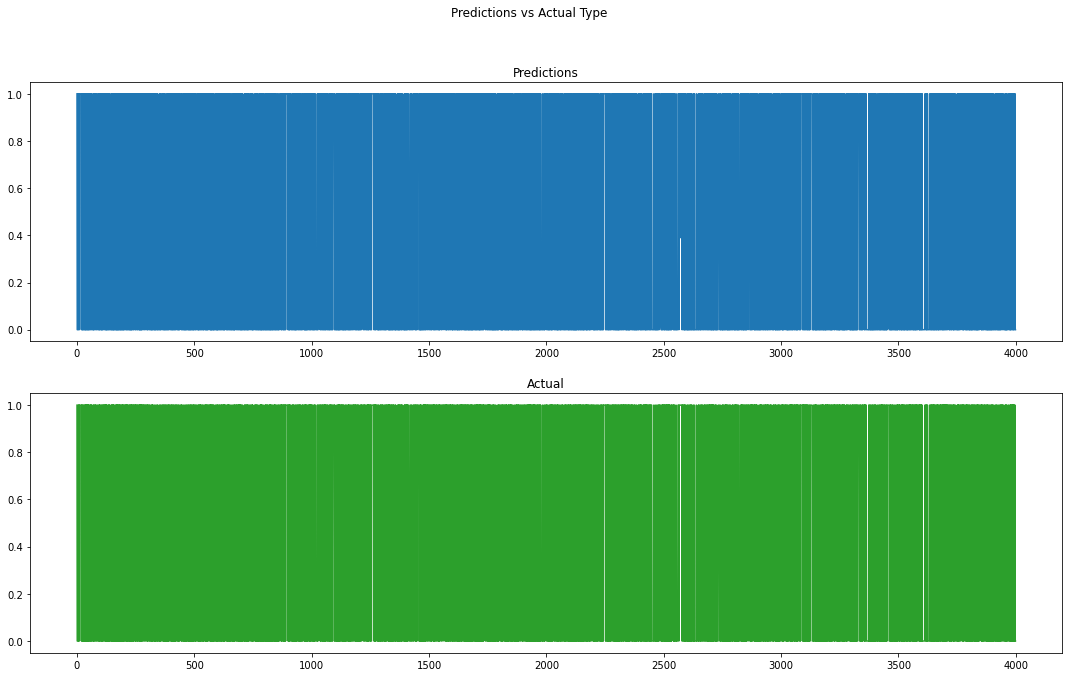

In [ ]:
fig, (ax1,ax2) = plt.subplots(2)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Predictions vs Actual Type')
ax1.plot(graphdat)
ax1.set_title('Predictions')
ax2.plot(targetlist, 'tab:green')
ax2.set_title('Actual')

Text(0.5, 1.0, 'Actual')

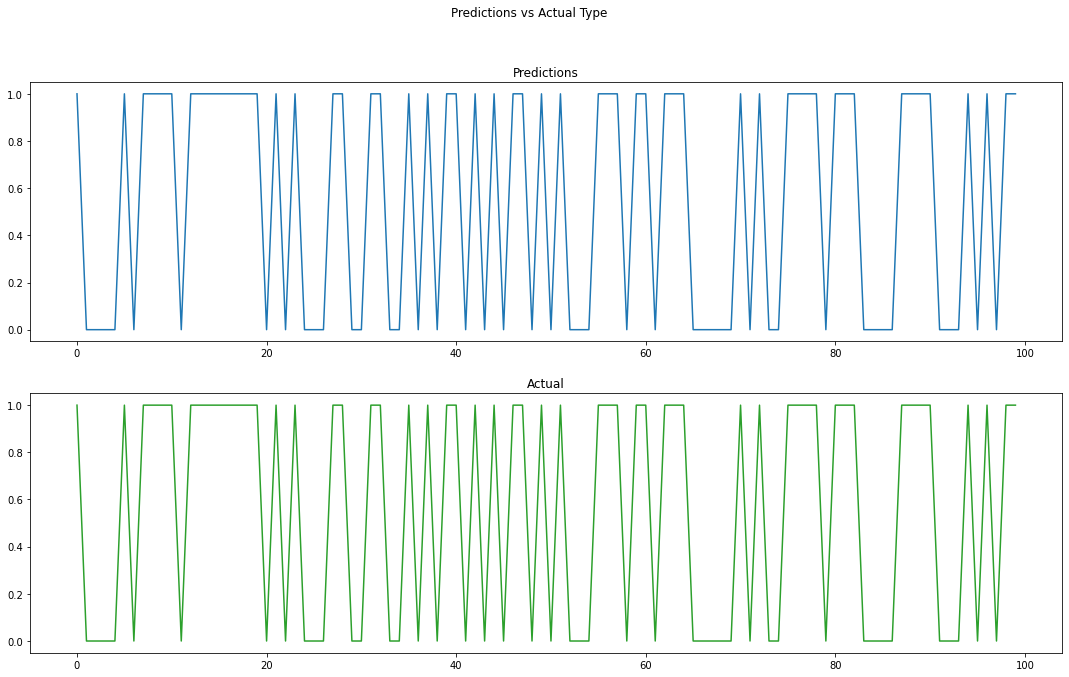

In [ ]:
fig, (ax1,ax2) = plt.subplots(2)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Predictions vs Actual Type')
ax1.plot(graphdat[0:100])
ax1.set_title('Predictions')
ax2.plot(targetlist[0:100], 'tab:green')
ax2.set_title('Actual')

Text(0.5, 1.0, 'Actual')

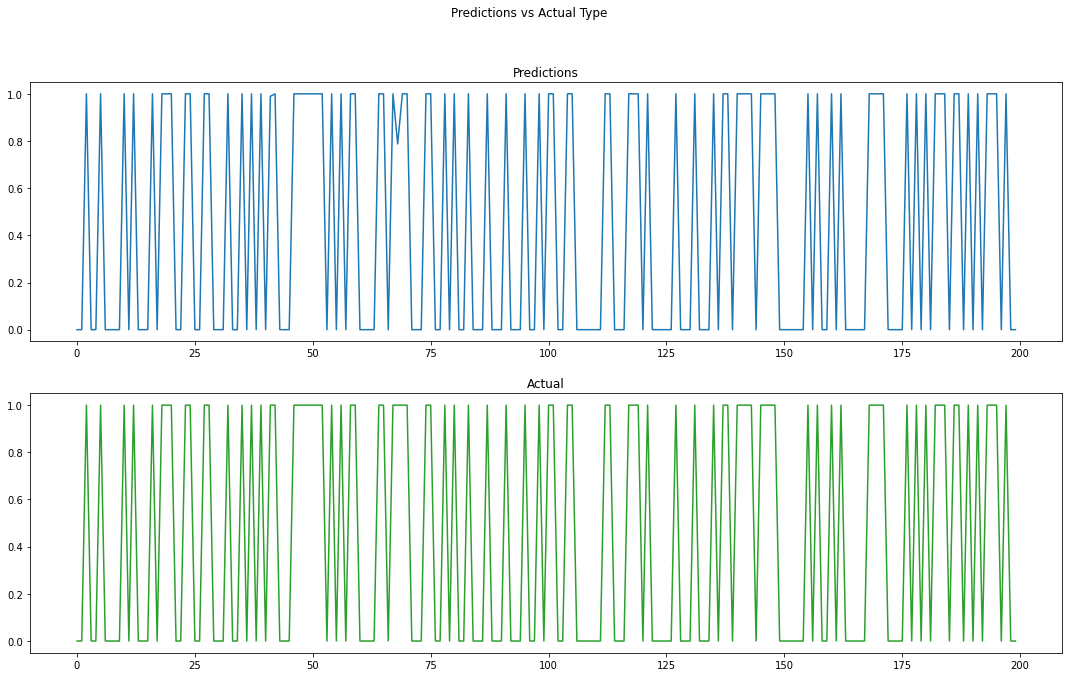

In [ ]:
fig, (ax1,ax2) = plt.subplots(2)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Predictions vs Actual Type')
ax1.plot(graphdat[3800:4000])
ax1.set_title('Predictions')
ax2.plot(targetlist[3800:4000], 'tab:green')
ax2.set_title('Actual')